XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190706-082538'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(1, 8),
    'learning_rate': sp.stats.uniform(0.0005, 0.5),
    'gamma': sp.stats.uniform(0, 1),
    'min_child_weight': sp.stats.randint(1, 15),
    'subsample': sp.stats.uniform(0.7, 0.3),
    'colsample_bytree': sp.stats.uniform(0.4, 0.6),
    'colsample_bylevel': sp.stats.uniform(0.4, 0.6),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

predictions = {}
actuals = {}
models = {}
for station in station_data_dict.keys():
    print(station)
    station_data = station_data_dict[station]
    
    station_train = station_data.loc[train_start : train_end].copy()
    num_validation_samples = int(validation_fraction * station_train.shape[0])
    shuffle_indices = np.arange(station_train.shape[0])
    np.random.shuffle(shuffle_indices)
    station_train = station_train.iloc[shuffle_indices]
    station_val, station_train = station_train.iloc[:num_validation_samples].copy(), station_train.iloc[num_validation_samples:].copy()
    
    station_test = station_data.loc[test_start : test_end]
    print('Shapes: train {}, val {}, test {}'.format(station_train.shape, station_val.shape, station_test.shape))

    station_val = [(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff']), 
                   (station_val.drop(['station', 'runoff'], axis=1), station_val['runoff'])]
    
    xgb_model = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, random_state=123)
    m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'], eval_set=station_val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)
    
    cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
    print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
    print('Best params: {}'.format(m.best_params_))
    print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue

    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    predict['runoff'] = m.predict(predict.drop('runoff', axis=1))

    predictions[station] = predict[['runoff']]
    actuals[station] = station_test['runoff']
    models[station] = m

02GA010
Shapes: train (980, 302), val (108, 302), test (730, 302)
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
9                  0.951434               0.996574    0.477048   
913                0.475969                0.78261    0.777607   
349                0.700763               0.796831     0.56879   
213                 0.88196               0.863367    0.147996   
297                0.475246               0.833914    0.972155   

    param_learning_rate param_max_depth param_min_child_weight  \
9              0.155442               6                      7   
913            0.290885               7                     14   
349           0.0529696               5                     12   
213           0.0461555               4                      7   
297            0.122793               5                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
9           6.59213          28.8646        0.732563      -126.468849   
913          3.8777           25.983        0.729904      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
393                0.857186               0.924186    0.282732   
912                0.436563               0.565916    0.033759   
558                0.480798                0.79715    0.949966   
984                 0.72686               0.921188    0.738864   
8                  0.505224                0.58898    0.891109   

    param_learning_rate param_max_depth param_min_child_weight  \
393            0.109912               3                     13   
912           0.0967708               7                     10   
558            0.256704               4                      8   
984           0.0300861               4                     12   
8             0.0906681               7                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
393         16.3985          8.51981        0.839281       -74.363249   
912         11.4989          5.69541        0.782446       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
43                 0.825774               0.975607    0.422543   
727                0.621642               0.659449    0.742579   
831                0.777861               0.893977    0.818992   
153                0.939975               0.825785    0.528818   
577                0.776003               0.963549    0.950625   

    param_learning_rate param_max_depth param_min_child_weight  \
43             0.123017               6                      8   
727            0.332268               7                      5   
831            0.276844               5                      4   
153           0.0275494               6                      2   
577            0.455128               5                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
43          7.16362          3.13925        0.727656       -48.937146   
727         17.9268          7.23359        0.788742       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
579                0.798786               0.484416    0.529452   
864                0.722112               0.730552     0.63341   
126                0.878917               0.909373    0.828347   
529                0.937504               0.885486    0.859321   
232                0.835762               0.727974    0.695974   

    param_learning_rate param_max_depth param_min_child_weight  \
579            0.210976               2                     13   
864            0.349512               3                      8   
126            0.197444               2                      2   
529            0.228991               2                     11   
232            0.145673               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
579         1.71676          13.0327        0.913822       -28.905347   
864         27.0075         0.395792        0.942712       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 12.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
188                0.519597               0.562186    0.897303   
526                0.942058                0.76405     0.74148   
438                0.591077               0.685277    0.477479   
705                0.493342               0.825052    0.557641   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
188           0.0551259               4                      3   
526           0.0156532               3                      5   
438           0.0171959               6                      9   
705           0.0154785               3                      8   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
188         18.7579          3.18025        0.871764     -1869.639959   
526         10.3233          10.7981        0.719761     -18

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
934                0.713163               0.752152  0.00593281   
769                 0.59907               0.865546    0.732138   
477                0.425825               0.555148    0.491633   
783                0.532312               0.616362   0.0368441   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
934            0.157647               3                      1   
769           0.0483023               6                      1   
477            0.131103               3                      8   
783             0.23277               2                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -14.648602   
934         2.62991          9.00795        0.881466       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
478                0.429302               0.630973     0.19667   
843                0.993312               0.756637    0.168727   
13                 0.515902               0.576216    0.817928   
778                0.565621                0.73908    0.340173   
145                0.460033               0.402031    0.285074   

    param_learning_rate param_max_depth param_min_child_weight  \
478            0.128774               7                      7   
843            0.316802               5                     10   
13             0.280244               5                     12   
778            0.150131               2                      3   
145           0.0826034               5                     11   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
478         1.14533          18.9353        0.757491       -58.441513   
843         4.18485          29.8714         0.84181       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
934                0.713163               0.752152  0.00593281   
213                 0.88196               0.863367    0.147996   
250                 0.40779               0.816308    0.988558   
361                0.562596               0.643391    0.342137   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
934            0.157647               3                      1   
213           0.0461555               4                      7   
250           0.0438701               2                      7   
361           0.0313684               3                     14   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
934         2.62991          9.00795        0.881466       -11.741293   
213         1.62598          32.7874        0.714266       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
58                 0.609711               0.566454    0.998918   
280                0.672979               0.456649    0.864732   
489                0.432155               0.969131    0.629412   
361                0.562596               0.643391    0.342137   
371                0.793562               0.594038    0.378886   

    param_learning_rate param_max_depth param_min_child_weight  \
58            0.0208081               3                     13   
280           0.0469065               5                     11   
489            0.088437               7                     11   
361           0.0313684               3                     14   
371           0.0545491               5                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
58         0.789366          28.5599        0.769027       -15.691663   
280         3.81508          15.0856         0.81862       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
627                0.644989               0.866446   0.0951399   
934                0.713163               0.752152  0.00593281   
595                0.479489               0.492719    0.364028   
416                0.792472               0.614149    0.843413   
992                0.911163               0.610604     0.53926   

    param_learning_rate param_max_depth param_min_child_weight  \
627            0.370329               3                      3   
934            0.157647               3                      1   
595           0.0468124               2                      1   
416           0.0288661               3                      4   
992           0.0176548               7                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
627         3.21867          5.19502        0.831581       -31.252092   
934         2.62991          9.00795        0.881466       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
912                0.436563               0.565916    0.033759   
799                 0.43933               0.951868    0.280325   
586                0.862192               0.888036    0.661307   
204                0.695613               0.497658     0.86181   
660                0.774493               0.405713   0.0949222   

    param_learning_rate param_max_depth param_min_child_weight  \
912           0.0967708               7                     10   
799            0.131242               7                     10   
586            0.100151               7                     12   
204           0.0854604               3                     14   
660            0.100846               5                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
912         11.4989          5.69541        0.782446       -44.731758   
799         14.7551          5.98346        0.762902       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
360                0.742425               0.599219    0.557439   
564                0.445087               0.698789    0.399486   
504                0.502022               0.768724    0.924166   
416                0.792472               0.614149    0.843413   
661                0.488336               0.492771    0.855693   

    param_learning_rate param_max_depth param_min_child_weight  \
360            0.159445               4                     11   
564            0.133108               5                      4   
504            0.132687               4                      9   
416           0.0288661               3                      4   
661            0.113508               6                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
360         19.9967          3.07273        0.861879       -18.936378   
564         20.9824          1.44855        0.785521       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
386                0.892822               0.823399    0.110007   
959                0.611361               0.829366    0.534803   
213                 0.88196               0.863367    0.147996   
207                0.552134               0.724503    0.127207   
253                0.818166               0.478179    0.972714   

    param_learning_rate param_max_depth param_min_child_weight  \
386            0.184569               3                      9   
959            0.150791               6                      1   
213           0.0461555               4                      7   
207           0.0822749               5                      5   
253           0.0572363               4                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
386         9.33443          40.0612        0.833637       -13.944438   
959         4.34486          38.6074        0.703122       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
660                0.774493               0.405713   0.0949222   
813                0.460739               0.559693    0.848938   
374                0.863913               0.938763     0.40279   
28                 0.589086               0.694906    0.820142   
211                0.751507               0.908091    0.939502   

    param_learning_rate param_max_depth param_min_child_weight  \
660            0.100846               5                     12   
813            0.186383               3                      3   
374            0.151028               5                     12   
28            0.0668102               5                     10   
211          0.00983328               4                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
660         10.0827          1.32193        0.902242       -81.290440   
813         2.42473          23.4065        0.769794       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
747                 0.99811               0.615706   0.0379134   
76                 0.657833               0.474696    0.243281   
343                0.781792               0.523897    0.745185   
866                0.446646               0.484044     0.27414   
97                 0.810896               0.691667     0.32491   

    param_learning_rate param_max_depth param_min_child_weight  \
747           0.0860007               6                     12   
76            0.0615703               5                     14   
343           0.0524398               7                      3   
866           0.0914834               7                     10   
97            0.0506072               6                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
747         40.2756         0.488772         0.72094      -248.467054   
76          16.1754          16.0869        0.813941      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
912                0.436563               0.565916    0.033759   
746                0.732317               0.871572    0.766739   
91                 0.666751               0.604838    0.678591   
140                0.939588               0.994744    0.220877   
799                 0.43933               0.951868    0.280325   

    param_learning_rate param_max_depth param_min_child_weight  \
912           0.0967708               7                     10   
746            0.240105               7                      7   
91             0.316916               5                     11   
140            0.346028               4                      9   
799            0.131242               7                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
912         11.4989          5.69541        0.782446       -38.386773   
746         4.75819          44.9594        0.859597       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
548                0.433644               0.957201    0.450304   
28                 0.589086               0.694906    0.820142   
722                0.826183               0.523814     0.80899   
769                 0.59907               0.865546    0.732138   
211                0.751507               0.908091    0.939502   

    param_learning_rate param_max_depth param_min_child_weight  \
548            0.128167               7                     12   
28            0.0668102               5                     10   
722           0.0962687               5                     11   
769           0.0483023               6                      1   
211          0.00983328               4                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
548        0.757815          3.20028         0.82702      -102.240865   
28          11.8196         0.835911        0.790155      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
586                0.862192               0.888036    0.661307   
349                0.700763               0.796831     0.56879   
481                0.728364               0.454441    0.606986   
371                0.793562               0.594038    0.378886   
97                 0.810896               0.691667     0.32491   

    param_learning_rate param_max_depth param_min_child_weight  \
586            0.100151               7                     12   
349           0.0529696               5                     12   
481           0.0869274               3                     12   
371           0.0545491               5                     10   
97            0.0506072               6                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
586           1.741          20.5964        0.802226       -24.014849   
349         31.1175         0.599391         0.83767       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
813                0.460739               0.559693    0.848938   
769                 0.59907               0.865546    0.732138   
456                0.469671               0.457264    0.664797   
323                0.499565               0.510439     0.43404   
153                0.939975               0.825785    0.528818   

    param_learning_rate param_max_depth param_min_child_weight  \
813            0.186383               3                      3   
769           0.0483023               6                      1   
456            0.289298               6                      5   
323            0.132261               6                      4   
153           0.0275494               6                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
813         2.42473          23.4065        0.769794      -150.613726   
769         2.66931         0.658186        0.798171      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
702                0.637222               0.681325    0.615064   
416                0.792472               0.614149    0.843413   
595                0.479489               0.492719    0.364028   
838                 0.78679               0.430562    0.599462   
635                0.796126               0.714058    0.191947   

    param_learning_rate param_max_depth param_min_child_weight  \
702            0.319229               3                      2   
416           0.0288661               3                      4   
595           0.0468124               2                      1   
838            0.222946               3                      3   
635           0.0346263               5                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
702         4.40265          1.97848        0.977474       -12.574533   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
331                0.562087               0.952993    0.592652   
143                0.896951               0.919467    0.107063   
458                0.828195               0.807969    0.904346   
478                0.429302               0.630973     0.19667   
710                0.451915               0.964603    0.298006   

    param_learning_rate param_max_depth param_min_child_weight  \
331           0.0678305               4                      3   
143            0.148904               5                      6   
458            0.106877               5                      6   
478            0.128774               7                      7   
710            0.153701               6                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
331         1.98385          29.3796        0.766596       -12.425294   
143        0.155197          23.1968        0.730131       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
502                 0.87837               0.727096     0.59956   
210                0.464325               0.791638    0.672919   
416                0.792472               0.614149    0.843413   
985                0.538815               0.692219   0.0712341   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
502            0.173053               2                      2   
210            0.162053               2                      3   
416           0.0288661               3                      4   
985           0.0758789               1                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -14.210928   
502         2.03016          2.52547        0.909141       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
995                0.449913                0.40828    0.505431   
502                 0.87837               0.727096     0.59956   
769                 0.59907               0.865546    0.732138   
992                0.911163               0.610604     0.53926   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
995            0.438744               2                      1   
502            0.173053               2                      2   
769           0.0483023               6                      1   
992           0.0176548               7                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -46.799445   
995         13.2544          1.00659        0.960582       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
502                 0.87837               0.727096     0.59956   
210                0.464325               0.791638    0.672919   
732                0.467348               0.805445   0.0247203   
766                0.825775               0.621775    0.236455   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
502            0.173053               2                      2   
210            0.162053               2                      3   
732            0.276532               2                      3   
766            0.211105               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003      -178.021904   
502         2.03016          2.52547        0.909141      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
249                0.555175                0.68515     0.23536   
769                 0.59907               0.865546    0.732138   
502                 0.87837               0.727096     0.59956   
343                0.781792               0.523897    0.745185   
312                0.666656               0.736227    0.364585   

    param_learning_rate param_max_depth param_min_child_weight  \
249            0.282615               2                      1   
769           0.0483023               6                      1   
502            0.173053               2                      2   
343           0.0524398               7                      3   
312            0.113877               7                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
249        0.995682          1.45319         0.80564        -3.910261   
769         2.66931         0.658186        0.798171        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
47                 0.737392               0.658892    0.360565   
521                0.901039               0.835501    0.324206   
249                0.555175                0.68515     0.23536   
593                0.415917                0.62334    0.565436   
566                0.668266               0.532163    0.994625   

    param_learning_rate param_max_depth param_min_child_weight  \
47              0.25983               1                      1   
521            0.437903               1                      1   
249            0.282615               2                      1   
593            0.167012               1                      1   
566            0.159181               5                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
47         0.597991          1.10957        0.735109       -30.889902   
521         8.01245          3.21553        0.931682       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
593                0.415917                0.62334    0.565436   
630                0.405075               0.984892    0.187969   
708                0.501907               0.479266    0.622857   
277                0.767336                0.89547    0.324881   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
593            0.167012               1                      1   
630           0.0546691               1                      4   
708           0.0716124               1                      5   
277           0.0942371               1                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -98.696117   
593         11.3059          8.84343        0.995033      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
593                0.415917                0.62334    0.565436   
389                0.785364               0.683708    0.186953   
462                0.853339               0.816173    0.212571   
610                 0.42905               0.436937    0.550224   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
593            0.167012               1                      1   
389            0.179953               1                      5   
462            0.162827               1                      3   
610             0.32264               1                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003      -647.407231   
593         11.3059          8.84343        0.995033      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
631                0.770465               0.560365    0.557289   
250                 0.40779               0.816308    0.988558   
313                0.521767               0.556307    0.121017   
751                0.490458               0.755026    0.342998   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
631            0.145192               2                      2   
250           0.0438701               2                      7   
313            0.237904               2                     12   
751            0.189597               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -25.023847   
631         10.6614          7.99432        0.759741       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 43.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
808                0.527554               0.796876    0.887477   
630                0.405075               0.984892    0.187969   
49                 0.591887               0.988301    0.156558   
950                0.791514               0.821553    0.935329   
414                0.437603               0.782193    0.337249   

    param_learning_rate param_max_depth param_min_child_weight  \
808            0.151143               1                     13   
630           0.0546691               1                      4   
49             0.102632               2                     10   
950            0.169327               1                      8   
414             0.13073               1                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
808         19.0996          23.3637        0.854716    -38999.507406   
630         16.6418          3.92112         0.78621    -390

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
999                0.917596               0.575961    0.382414   
210                0.464325               0.791638    0.672919   
322                 0.54595               0.727617   0.0516954   
303                0.765207                0.83259     0.78578   
892                0.888422               0.856093    0.232337   

    param_learning_rate param_max_depth param_min_child_weight  \
999            0.138932               4                      6   
210            0.162053               2                      3   
322            0.137391               2                      7   
303            0.295506               2                      6   
892            0.134882               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
999         5.47995         0.280702        0.903819      -737.732797   
210          3.4549          4.26172        0.833611      -7

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
999                0.917596               0.575961    0.382414   
595                0.479489               0.492719    0.364028   
631                0.770465               0.560365    0.557289   
416                0.792472               0.614149    0.843413   
605                0.730034               0.940146    0.239294   

    param_learning_rate param_max_depth param_min_child_weight  \
999            0.138932               4                      6   
595           0.0468124               2                      1   
631            0.145192               2                      2   
416           0.0288661               3                      4   
605            0.216704               3                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
999         5.47995         0.280702        0.903819      -156.112816   
595         2.16514         0.317428        0.818003      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
114                0.626873               0.629266   0.0511263   
416                0.792472               0.614149    0.843413   
806                0.891677               0.805518    0.985636   
635                0.796126               0.714058    0.191947   
44                 0.761759               0.618512     0.56457   

    param_learning_rate param_max_depth param_min_child_weight  \
114            0.213836               6                      9   
416           0.0288661               3                      4   
806            0.073978               4                      6   
635           0.0346263               5                      8   
44            0.0961679               5                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
114        0.611115          8.28303        0.946291       -47.390773   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
496                0.403206               0.952049    0.971255   
650                0.642457               0.855554    0.667817   
157                0.990155               0.567304    0.101912   
327                0.747414               0.887742    0.150078   
595                0.479489               0.492719    0.364028   

    param_learning_rate param_max_depth param_min_child_weight  \
496            0.117535               2                      1   
650           0.0709069               2                      6   
157            0.146573               3                      7   
327            0.180564               2                      6   
595           0.0468124               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
496         66.3817          4.69541        0.860785     -2680.433428   
650         15.2017          8.02298        0.830693     -26

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
78                 0.997517               0.795261    0.196009   
213                 0.88196               0.863367    0.147996   
203                0.832377               0.481782      0.4941   
140                0.939588               0.994744    0.220877   
253                0.818166               0.478179    0.972714   

    param_learning_rate param_max_depth param_min_child_weight  \
78             0.049592               7                      7   
213           0.0461555               4                      7   
203            0.385016               7                     11   
140            0.346028               4                      9   
253           0.0572363               4                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
78          57.9278          19.4217        0.705097      -541.070856   
213         1.62598          32.7874        0.714266      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
49                 0.591887               0.988301    0.156558   
157                0.990155               0.567304    0.101912   
655                0.627227               0.870566    0.653952   
206                0.756372               0.463581    0.685345   
95                 0.559058               0.476433    0.987936   

    param_learning_rate param_max_depth param_min_child_weight  \
49             0.102632               2                     10   
157            0.146573               3                      7   
655            0.263483               2                      6   
206            0.108453               2                      8   
95             0.418172               7                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
49          12.9954          1.40297        0.857238      -252.028589   
157         48.2035          0.41768        0.797427      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
206                0.756372               0.463581    0.685345   
679                0.574764                0.68462    0.849544   
496                0.403206               0.952049    0.971255   
732                0.467348               0.805445   0.0247203   
469                0.768802               0.989713    0.750598   

    param_learning_rate param_max_depth param_min_child_weight  \
206            0.108453               2                      8   
679            0.228244               2                      3   
496            0.117535               2                      1   
732            0.276532               2                      3   
469             0.23823               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
206         26.7475          11.8644        0.847172      -464.836467   
679        0.225663          19.9625        0.818831      -4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
526                0.942058                0.76405     0.74148   
41                  0.90235               0.610457    0.911389   
416                0.792472               0.614149    0.843413   
660                0.774493               0.405713   0.0949222   
533                 0.69131               0.619537    0.580516   

    param_learning_rate param_max_depth param_min_child_weight  \
526           0.0156532               3                      5   
41             0.200706               4                      5   
416           0.0288661               3                      4   
660            0.100846               5                     12   
533           0.0889042               3                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
526         10.3233          10.7981        0.719761       -15.297588   
41          10.2921          2.19611        0.839778       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
322                 0.54595               0.727617   0.0516954   
502                 0.87837               0.727096     0.59956   
631                0.770465               0.560365    0.557289   
955                0.428398               0.557488    0.566875   
544                0.738344                0.75687    0.310562   

    param_learning_rate param_max_depth param_min_child_weight  \
322            0.137391               2                      7   
502            0.173053               2                      2   
631            0.145192               2                      2   
955            0.222212               2                      1   
544           0.0448832               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
322         22.7941          7.65049        0.715262      -684.610173   
502         2.03016          2.52547        0.909141      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
49                 0.591887               0.988301    0.156558   
529                0.937504               0.885486    0.859321   
751                0.490458               0.755026    0.342998   
191                0.604612               0.656383    0.916189   
595                0.479489               0.492719    0.364028   

    param_learning_rate param_max_depth param_min_child_weight  \
49             0.102632               2                     10   
529            0.228991               2                     11   
751            0.189597               2                      1   
191            0.257259               2                      7   
595           0.0468124               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
49          12.9954          1.40297        0.857238      -278.879764   
529          1.9684         0.270873        0.981977      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
327                0.747414               0.887742    0.150078   
204                0.695613               0.497658     0.86181   
157                0.990155               0.567304    0.101912   
660                0.774493               0.405713   0.0949222   
430                0.680179               0.425847    0.435679   

    param_learning_rate param_max_depth param_min_child_weight  \
327            0.180564               2                      6   
204           0.0854604               3                     14   
157            0.146573               3                      7   
660            0.100846               5                     12   
430             0.19881               2                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
327          14.604             3.57        0.960825      -856.648050   
204          4.5028          15.3554        0.964252      -8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
239                0.758659               0.870249     0.26401   
99                 0.629916               0.816193    0.689953   
775                0.533622               0.537457    0.558341   
674                 0.50557               0.982876    0.141924   
411                0.831573               0.438447    0.846542   

    param_learning_rate param_max_depth param_min_child_weight  \
239           0.0659127               4                      5   
99             0.217655               3                      5   
775            0.126293               4                      3   
674            0.146919               4                      1   
411            0.291848               4                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
239         21.7675          12.7068        0.782758       -85.096350   
99          28.8162          11.3226         0.87226       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
947                 0.66488               0.682824     0.33541   
371                0.793562               0.594038    0.378886   
474                 0.69314               0.405035    0.178761   
297                0.475246               0.833914    0.972155   
149                0.954451               0.865575    0.243222   

    param_learning_rate param_max_depth param_min_child_weight  \
947            0.186214               6                     11   
371           0.0545491               5                     10   
474           0.0650908               3                     13   
297            0.122793               5                      9   
149           0.0489263               7                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
947         5.66885          25.9186        0.733436      -382.830522   
371         12.9066          14.6936        0.760703      -3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1087 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1357 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1663 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2005 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 2383 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 2797 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   21.0s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/cor

    param_colsample_bylevel param_colsample_bytree param_gamma  \
769                 0.59907               0.865546    0.732138   
495                0.545221               0.522333    0.216999   
370                0.771188               0.567218    0.204272   
702                0.637222               0.681325    0.615064   
838                 0.78679               0.430562    0.599462   

    param_learning_rate param_max_depth param_min_child_weight  \
769           0.0483023               6                      1   
495            0.432603               3                      1   
370            0.492206               3                      6   
702            0.319229               3                      2   
838            0.222946               3                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
769         2.66931         0.658186        0.798171      -116.193915   
495         2.46533         0.430331        0.917938      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
188                0.519597               0.562186    0.897303   
213                 0.88196               0.863367    0.147996   
611                0.937346                0.74278     0.68795   
879                0.559733               0.958071    0.511007   
331                0.562087               0.952993    0.592652   

    param_learning_rate param_max_depth param_min_child_weight  \
188           0.0551259               4                      3   
213           0.0461555               4                      7   
611             0.18056               3                      6   
879           0.0871464               4                      1   
331           0.0678305               4                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
188         18.7579          3.18025        0.871764       -44.539785   
213         1.62598          32.7874        0.714266       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   53.9s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
38                 0.776969               0.980507    0.281418   
641                0.781352               0.445102    0.664482   
522                 0.92684               0.783719     0.77108   
373                0.557286               0.566788    0.817387   
352                0.409242               0.592922    0.594696   

    param_learning_rate param_max_depth param_min_child_weight  \
38             0.123698               6                      8   
641            0.228526               6                     12   
522            0.158659               3                      8   
373            0.174915               5                     10   
352            0.170511               6                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
38          44.5265         0.703116        0.847443       -82.718195   
641         11.1481          2.70895         0.98426       -

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


02GA010 	NSE: 0.3235262756625451 	MSE: 322.524777863079 (clipped to 0)
02GA018 	NSE: 0.32252551755819725 	MSE: 170.14987097423077 (clipped to 0)
02GA038 	NSE: 0.3631925367484362 	MSE: 104.77931736425336 (clipped to 0)
02GA047 	NSE: 0.20849059629911226 	MSE: 62.04644167842031 (clipped to 0)
02GB001 	NSE: 0.300568018705058 	MSE: 5252.64688943629 (clipped to 0)
02GB007 	NSE: 0.4180577840150761 	MSE: 18.198505433157344 (clipped to 0)
02GC002 	NSE: 0.5319289318851803 	MSE: 60.14855267080992 (clipped to 0)
02GC007 	NSE: 0.5436439934960773 	MSE: 13.746056474597417 (clipped to 0)
02GC010 	NSE: 0.5220620599925132 	MSE: 28.41337220228126 (clipped to 0)
02GC018 	NSE: 0.46202925121996496 	MSE: 36.43503823599244 (clipped to 0)
02GC026 	NSE: 0.5646737473405916 	MSE: 70.01471981709372 (clipped to 0)
02GD004 	NSE: 0.4672146199495726 	MSE: 29.33680049507388 (clipped to 0)
02GE007 	NSE: 0.41112701105473426 	MSE: 21.30251481216862 (clipped to 0)
02GG002 	NSE: 0.5930052869365463 	MSE: 98.16013523773222 (c

../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04160600 	NSE: 0.666221324763711 	MSE: 9.65652263152795 (clipped to 0)
04161820 	NSE: 0.4278118949575618 	MSE: 18.068584081840687 (clipped to 0)
04164000 	NSE: 0.5225294924635211 	MSE: 83.6658953921328 (clipped to 0)
04165500 	NSE: 0.6231631354746384 	MSE: 168.69438302589194 (clipped to 0)
04166100 	NSE: 0.5975178232866429 	MSE: 2.9515256400193297 (clipped to 0)
04166500 	NSE: 0.63735570226305 	MSE: 12.534543528826065 (clipped to 0)
04174500 	NSE: 0.2560306294180741 	MSE: 70.36033526600535 (clipped to 0)
04176500 	NSE: 0.14203395785131578 	MSE: 586.0544819154907 (clipped to 0)
04177000 	NSE: 0.1314257288053211 	MSE: 23.40792878695095 (clipped to 0)
04193500 	NSE: 0.5619990155464796 	MSE: 31010.79787935949 (clipped to 0)
04195820 	NSE: 0.6384668927249384 	MSE: 424.36551333117285 (clipped to 0)
04196800 	NSE: 0.4309585120959337 	MSE: 170.28480428301722 (clipped to 0)
04197100 	NSE: 0.5398279152637329 	MSE: 47.197278251342496 (clipped to 0)
04198000 	NSE: 0.5560741789667554 	MSE: 3279.528

../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04199000 	NSE: 0.47660296589059137 	MSE: 535.2275341784008 (clipped to 0)
04199500 	NSE: 0.5906861117519349 	MSE: 165.6280961717754 (clipped to 0)
04200500 	NSE: 0.496708466934602 	MSE: 503.6463314049434 (clipped to 0)
04207200 	NSE: 0.5684126400005045 	MSE: 10.101859467271666 (clipped to 0)
04208504 	NSE: 0.5750679791067441 	MSE: 414.9582953278374 (clipped to 0)
04209000 	NSE: 0.530049637436335 	MSE: 146.93280807643347 (clipped to 0)
04212100 	NSE: 0.5322743706501873 	MSE: 686.7732521729534 (clipped to 0)
04213000 	NSE: 0.4085190244232799 	MSE: 106.15263902190188 (clipped to 0)
04213500 	NSE: 0.5546745495106622 	MSE: 456.1988922833612 (clipped to 0)
04214500 	NSE: -0.20600531332203498 	MSE: 145.36836744070993 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04215000 	NSE: 0.5290748971940649 	MSE: 45.23368075196893 (clipped to 0)
04215500 	NSE: 0.44286791317519847 	MSE: 100.60964861911276 (clipped to 0)
Median NSE (clipped to 0) 0.5222957762280172 / Min -0.20600531332203498 / Max 0.666221324763711
Median MSE (clipped to 0) 96.82126751132567 / Min 2.9515256400193297 / Max 31010.79787935949


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


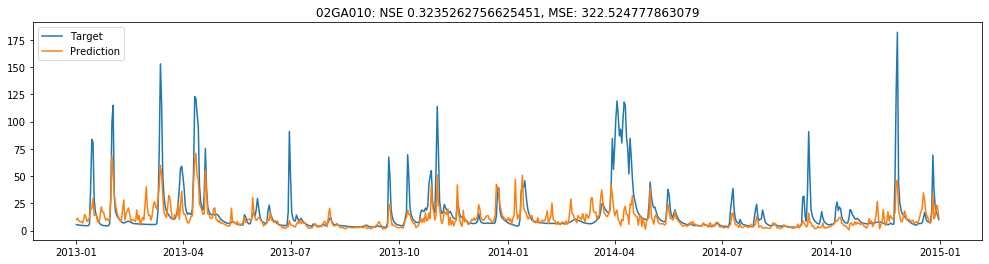

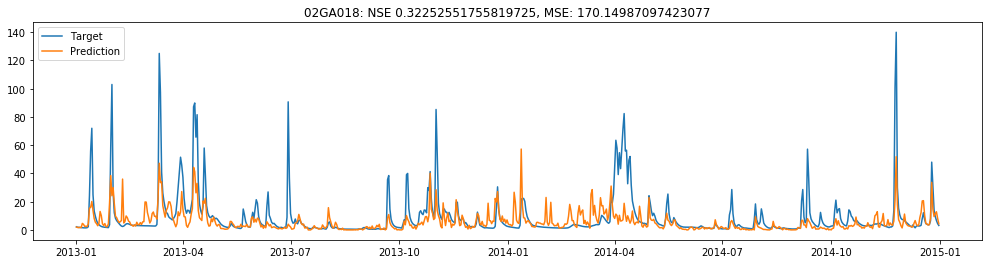

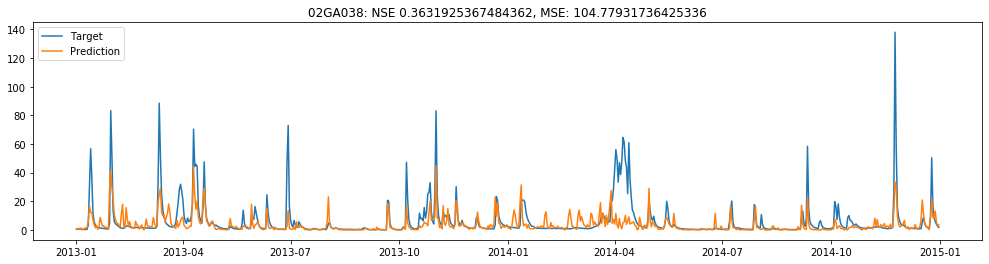

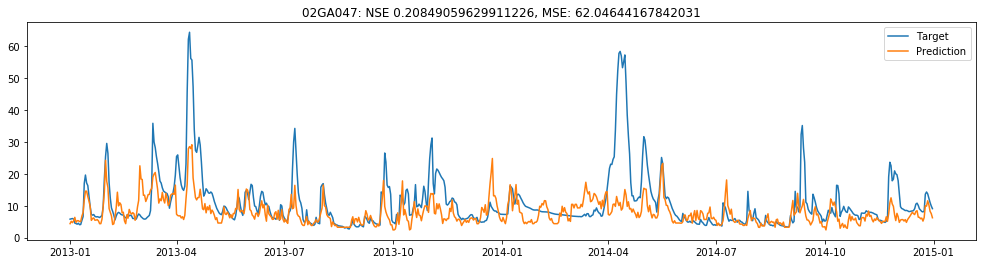

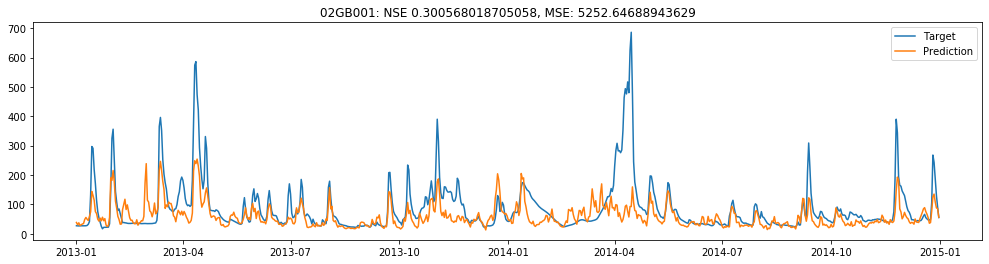

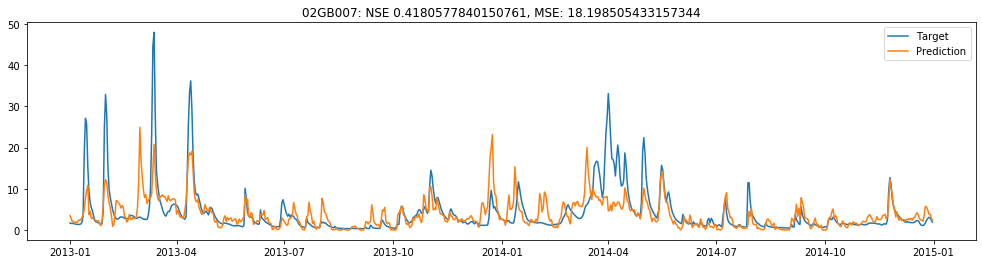

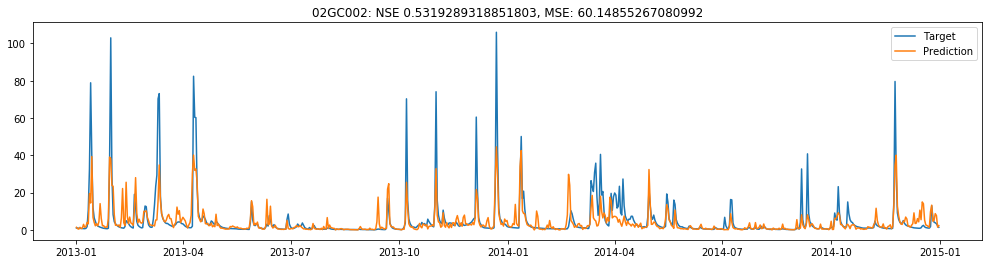

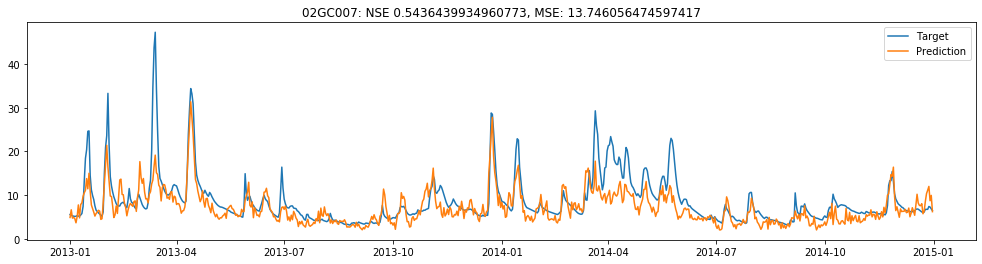

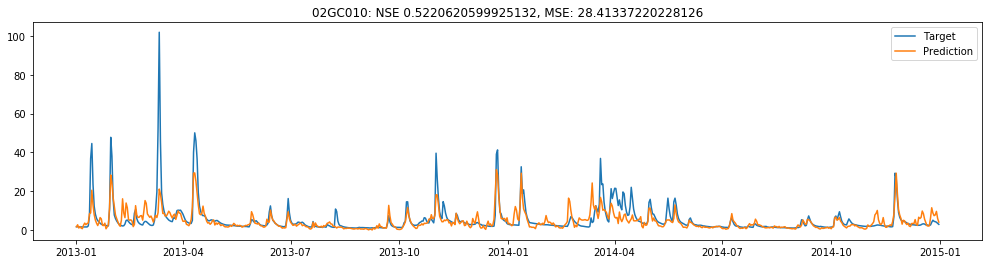

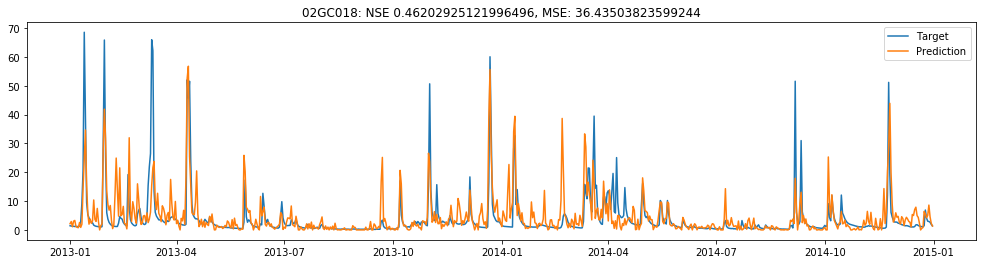

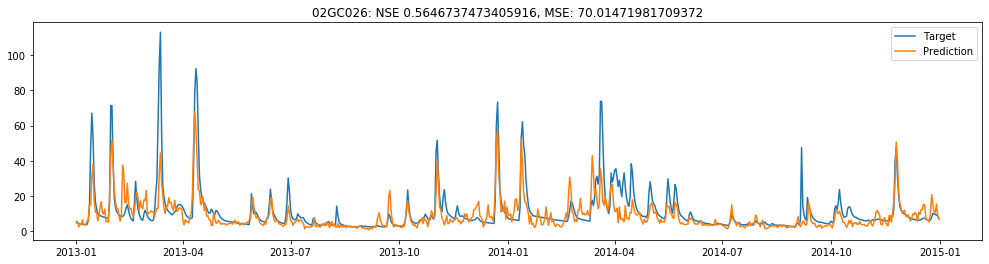

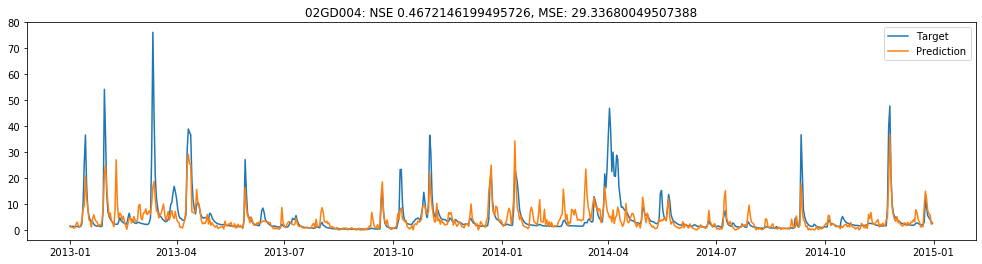

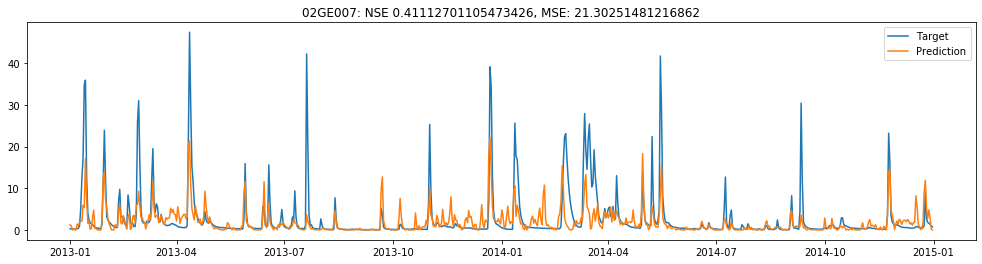

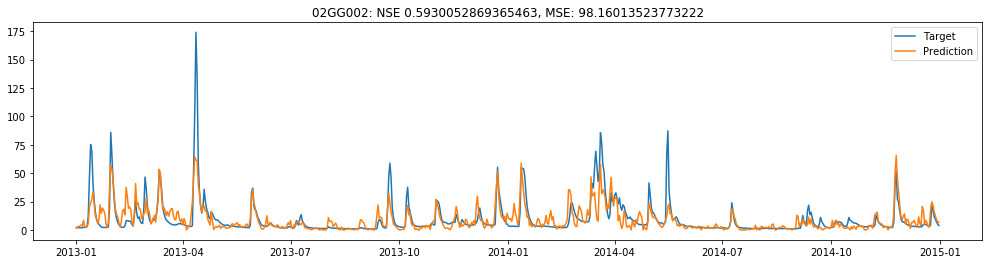

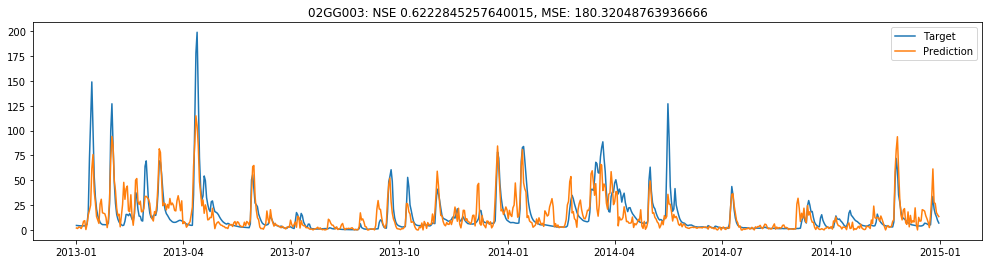

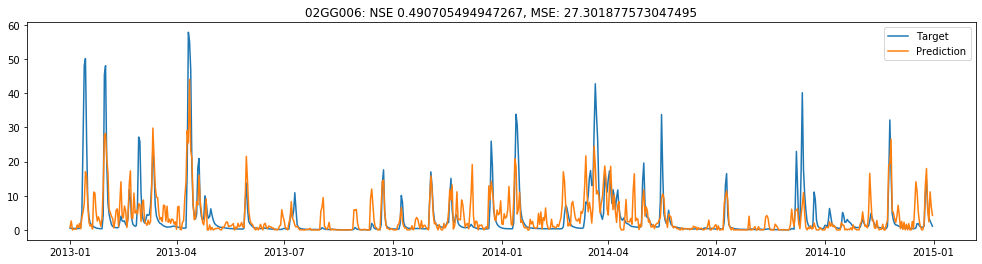

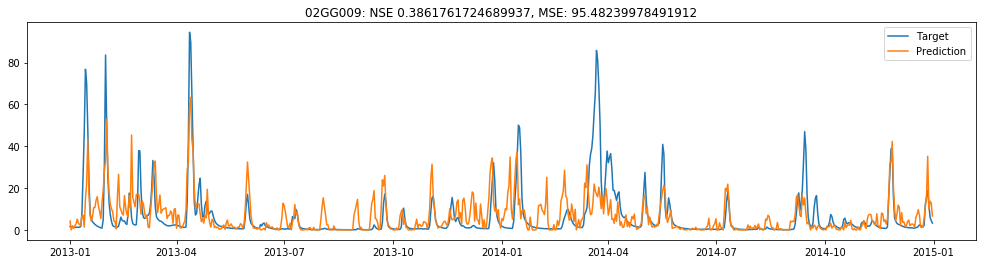

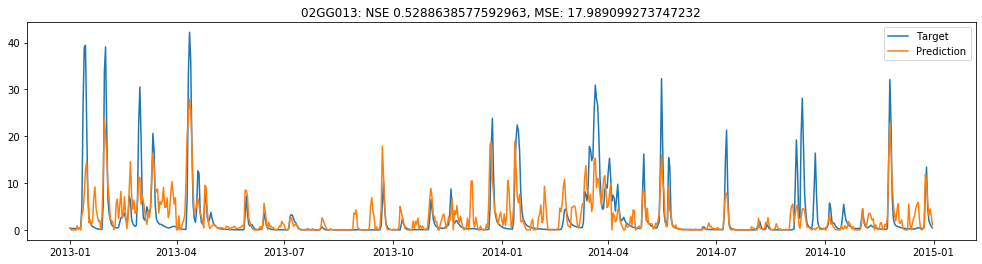

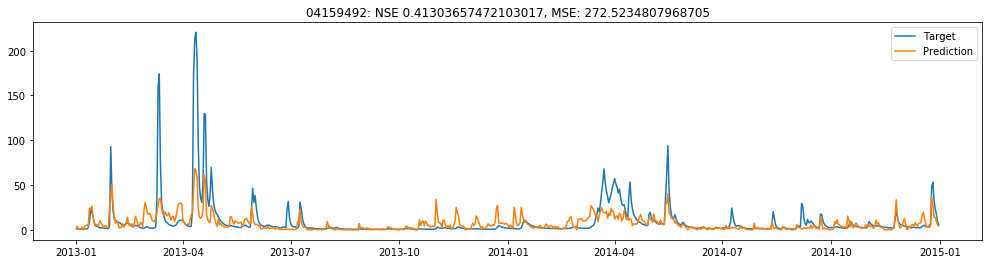

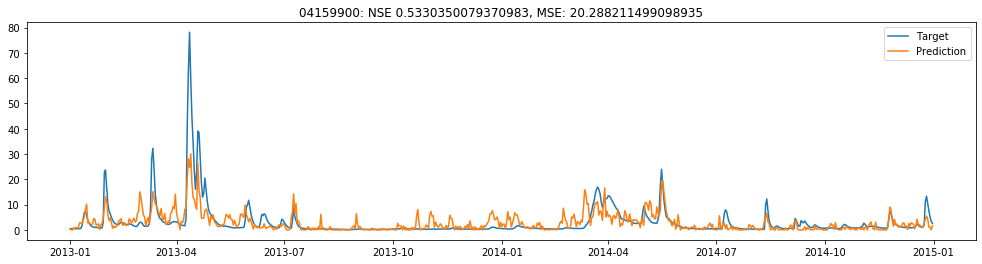

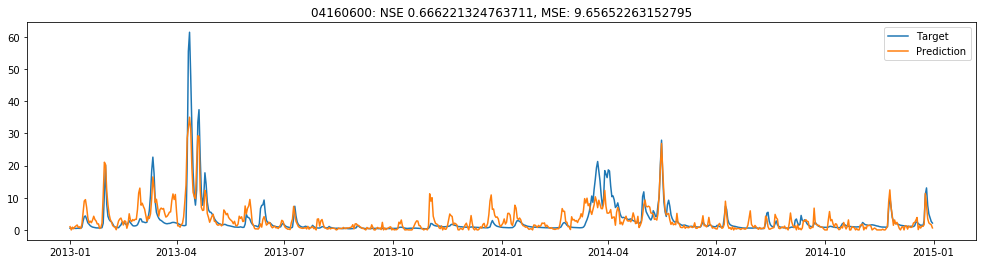

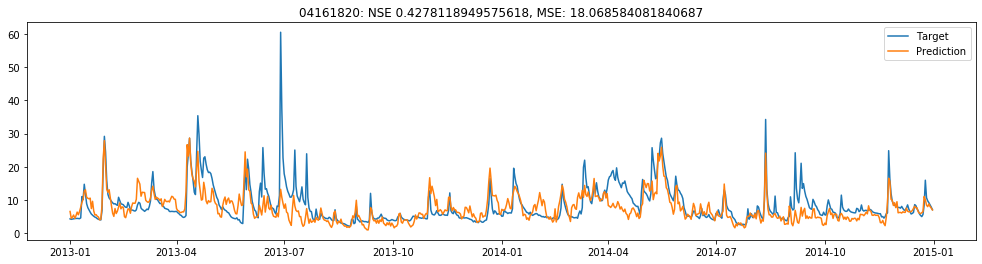

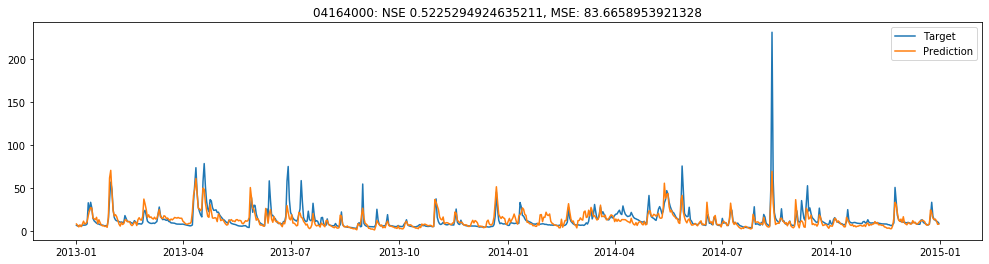

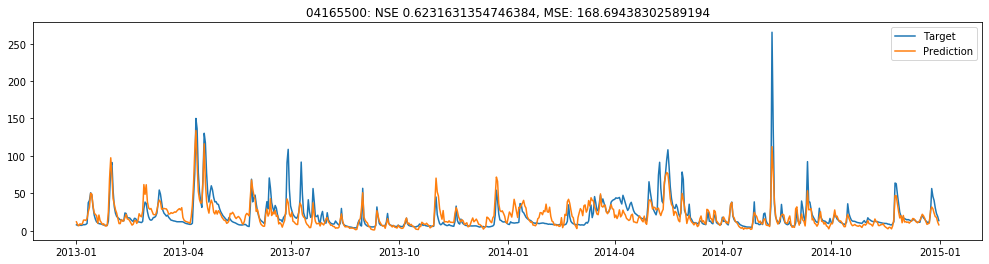

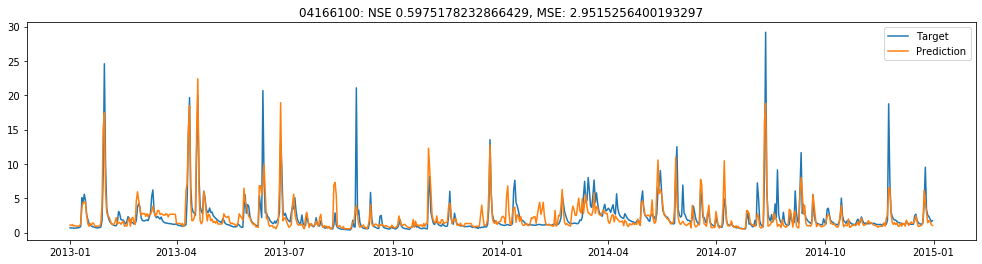

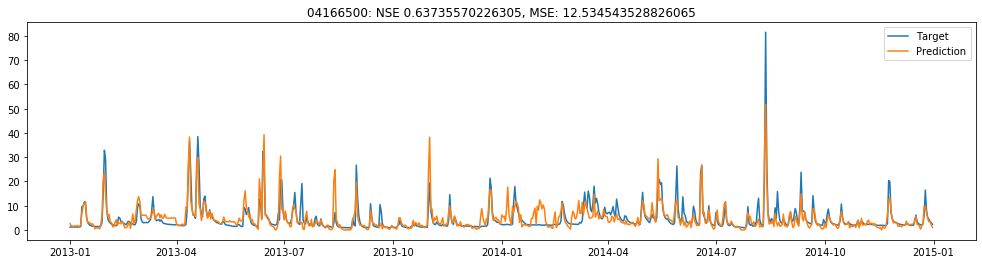

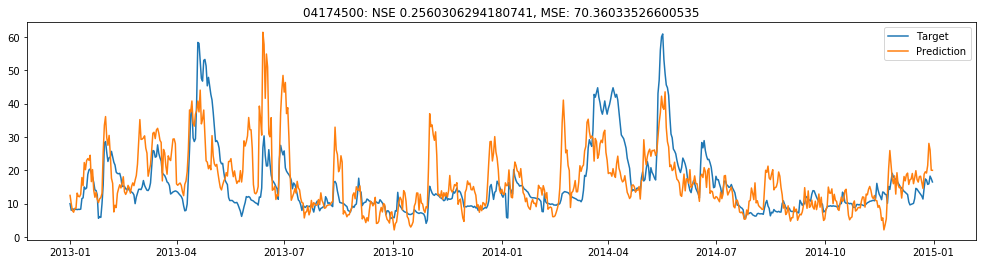

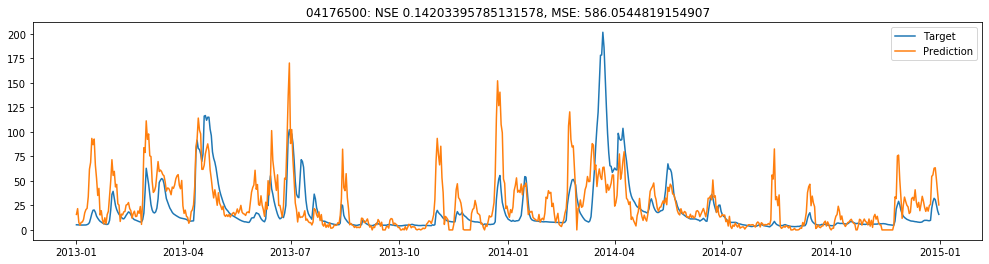

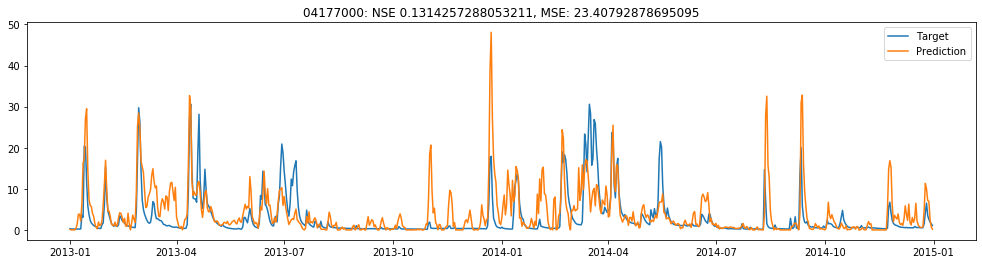

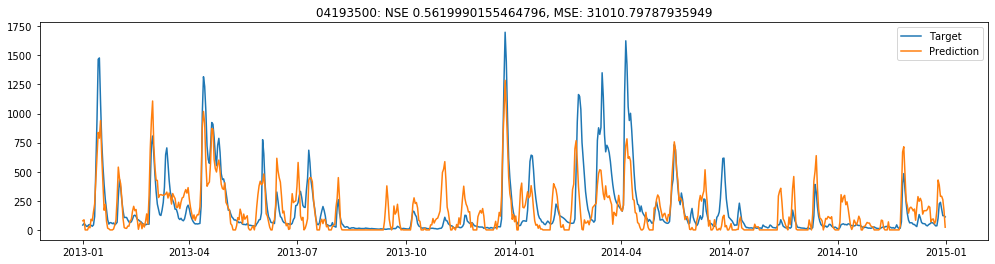

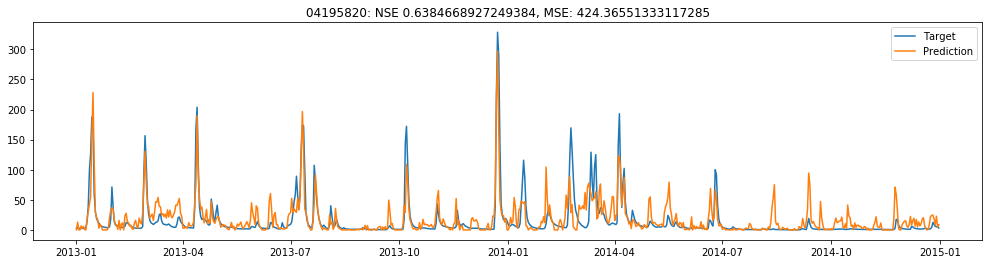

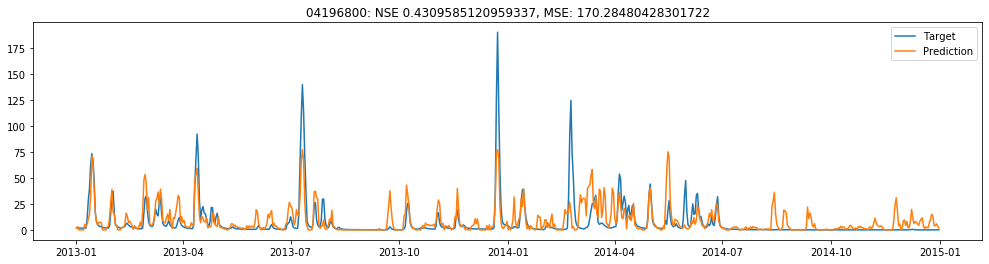

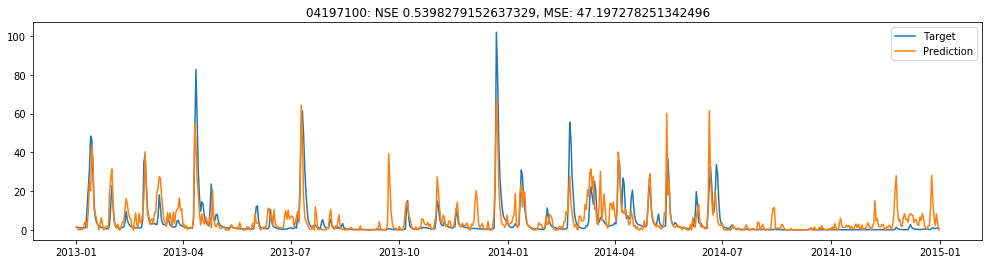

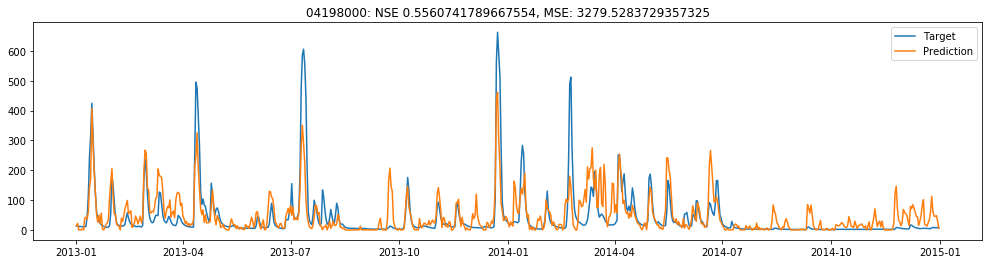

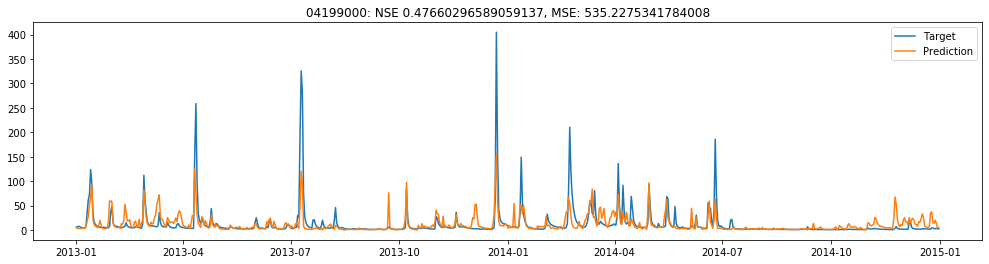

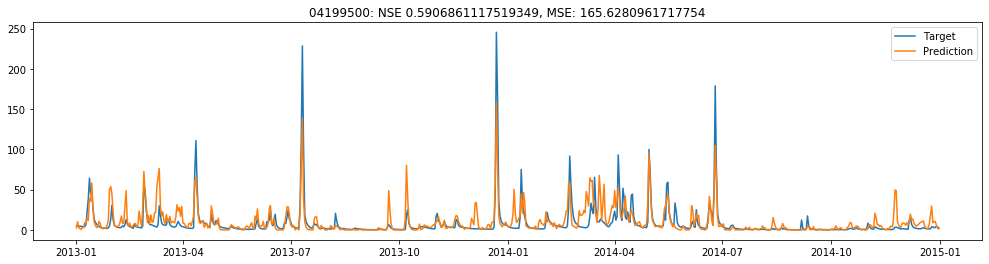

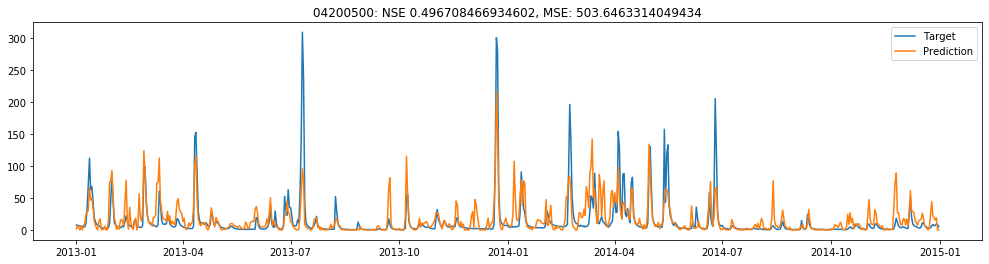

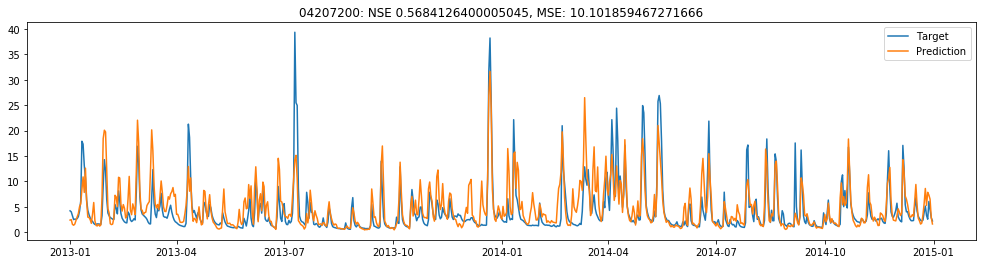

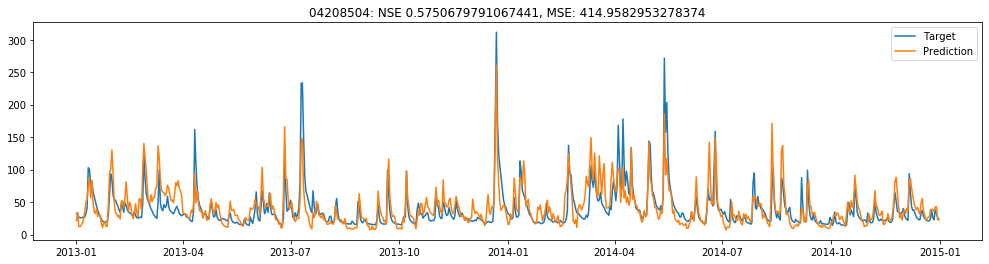

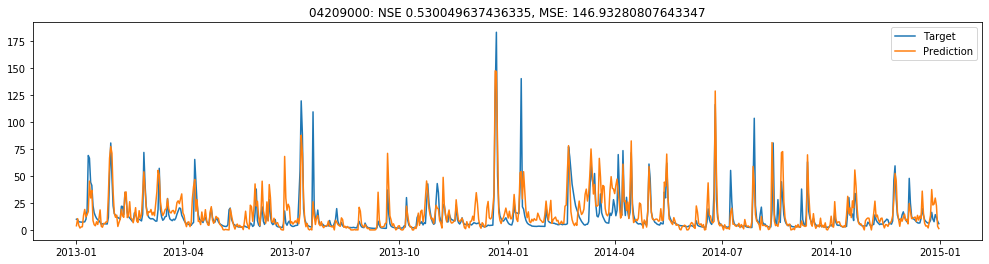

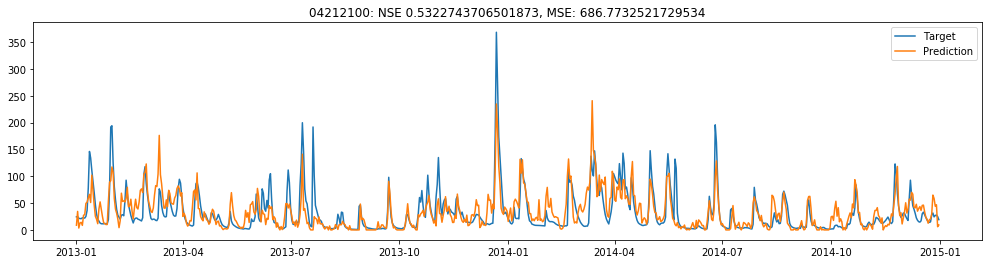

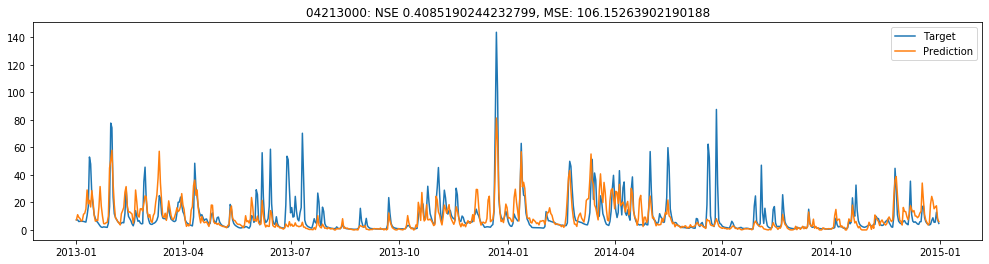

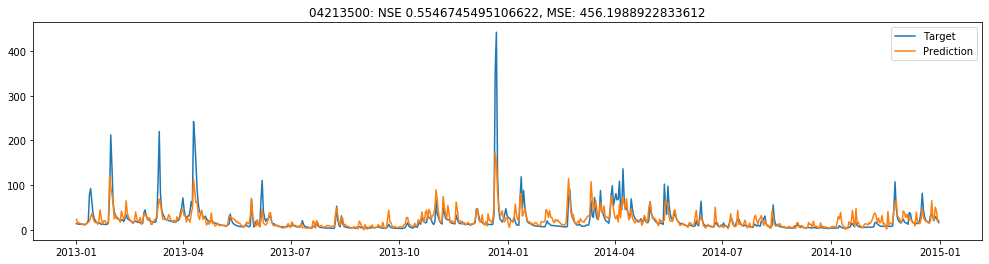

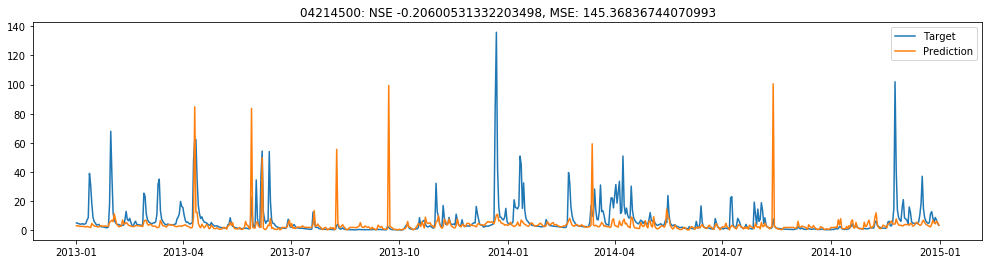

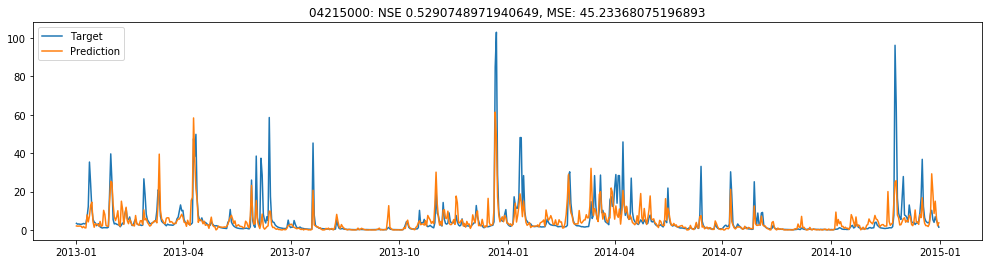

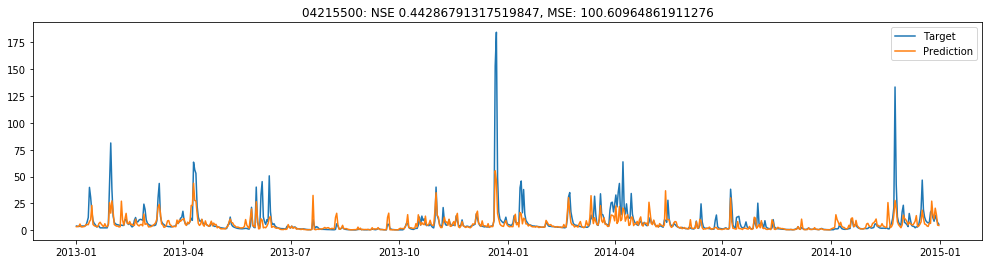

In [5]:
nse_list = []
mse_list = []
for station, predict in predictions.items():
    nse, mse = evaluate.evaluate_daily(station, predict, actuals[station], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings', (predictions, actuals), time_stamp)

'XGBoost_VIC_aggregateForcings_20190706-082538.pkl'

In [7]:
for station, model in models.items():
    load_data.pickle_model('XGBoost_VIC_aggregateForcings', model, station, time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA010_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA018_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA038_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA047_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB001_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB007_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC002_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC007_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC010_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC018_20190706-082538.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC026_20190706-082538.pkl
Saved mode